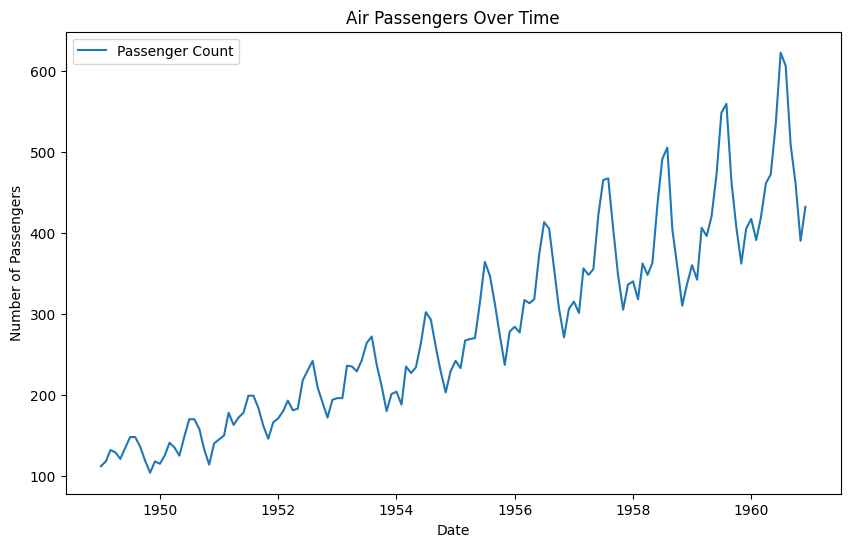

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('AirPassengers.csv')

# Convert Month to datetime format and set as index
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['#Passengers'], label='Passenger Count')
plt.title('Air Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Prepare the training and test sets
train_size = int(len(data_scaled) * 0.80)
train, test = data_scaled[:train_size], data_scaled[train_size:]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time steps
time_step = 12  

X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


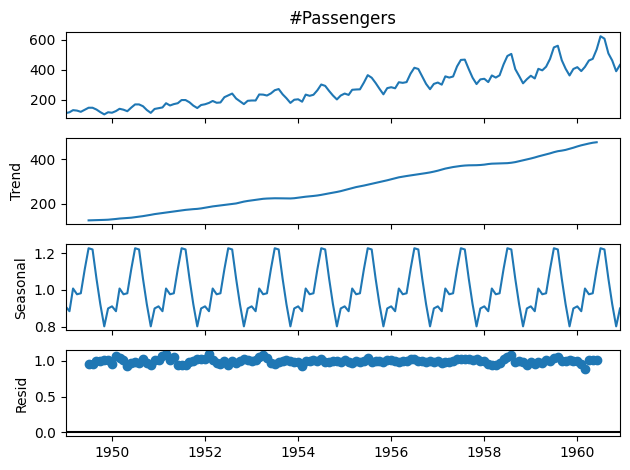

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(data['#Passengers'], model='multiplicative', period=12)
decomposition.plot()
plt.show()


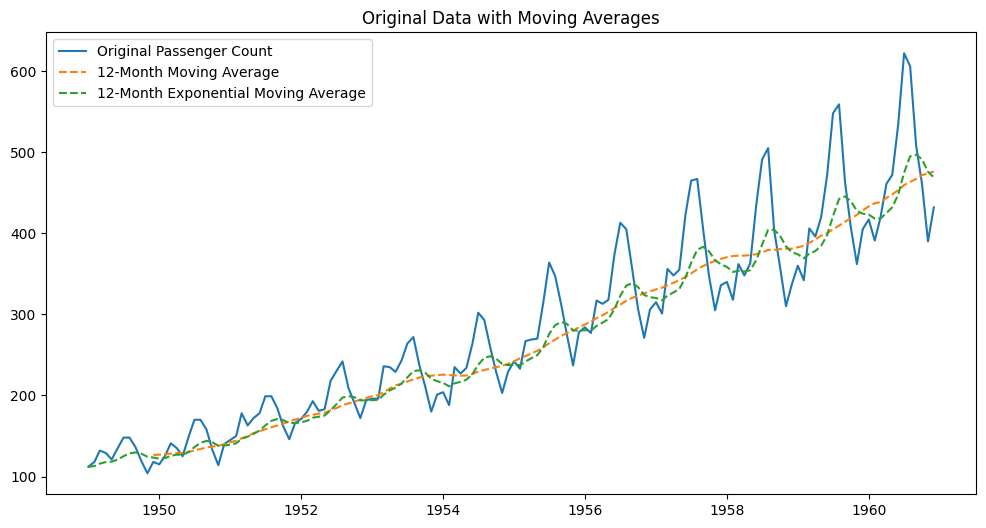

In [3]:
# Calculate Moving Averages (MA) and Exponential Moving Averages (EMA)
data['MA_12'] = data['#Passengers'].rolling(window=12).mean()
data['EMA_12'] = data['#Passengers'].ewm(span=12, adjust=False).mean()

# Plot original data with MA and EMA
plt.figure(figsize=(12, 6))
plt.plot(data['#Passengers'], label='Original Passenger Count')
plt.plot(data['MA_12'], label='12-Month Moving Average', linestyle='--')
plt.plot(data['EMA_12'], label='12-Month Exponential Moving Average', linestyle='--')
plt.title('Original Data with Moving Averages')
plt.legend()
plt.show()


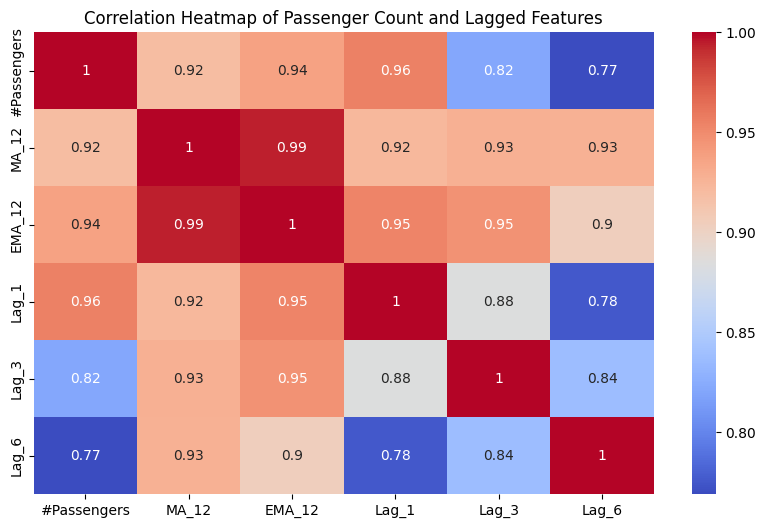

In [4]:
# Create lagged features for correlation analysis (e.g., lagging by 1, 3, 6 months)
data['Lag_1'] = data['#Passengers'].shift(1)
data['Lag_3'] = data['#Passengers'].shift(3)
data['Lag_6'] = data['#Passengers'].shift(6)

# Drop rows with NaN values introduced by the lagging process
lagged_data = data.dropna()

# Calculate the correlation matrix
corr_matrix = lagged_data.corr()

# Plot the correlation heatmap
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Passenger Count and Lagged Features')
plt.show()


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
lstm_model.add(Dense(1))  # Output layer

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict_lstm = lstm_model.predict(X_train)
test_predict_lstm = lstm_model.predict(X_test)

# Inverse transform to get actual values
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 479ms/step - loss: 0.1121 - val_loss: 0.3963
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0727 - val_loss: 0.2581
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0399 - val_loss: 0.1458
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0199 - val_loss: 0.0636
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0098 - val_loss: 0.0257
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0150 - val_loss: 0.0232
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0190 - val_loss: 0.0232
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0149 - val_loss: 0.0281
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0100 - val_loss: 0.0408
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0075 - val_loss: 0.0549
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0084 - val_loss: 0.0648
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0098 - val_l

In [6]:
from tensorflow.keras.layers import GRU

# GRU Model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dropout(0.2))  # Dropout layer to reduce overfitting
gru_model.add(Dense(1))  # Output layer

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
gru_history = gru_model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict_gru = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)

# Inverse transform to get actual values
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)


Epoch 1/500


C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 825ms/step - loss: 0.0860 - val_loss: 0.2556
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0472 - val_loss: 0.1203
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0181 - val_loss: 0.0453
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0099 - val_loss: 0.0248
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0145 - val_loss: 0.0247
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0215 - val_loss: 0.0244
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0152 - val_loss: 0.0276
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0096 - val_loss: 0.0368
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0077 - val_loss: 0.0486
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0081 - val_loss: 0.0569
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0109 - val_loss: 0.0586
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0102 - val_loss: 0.0539


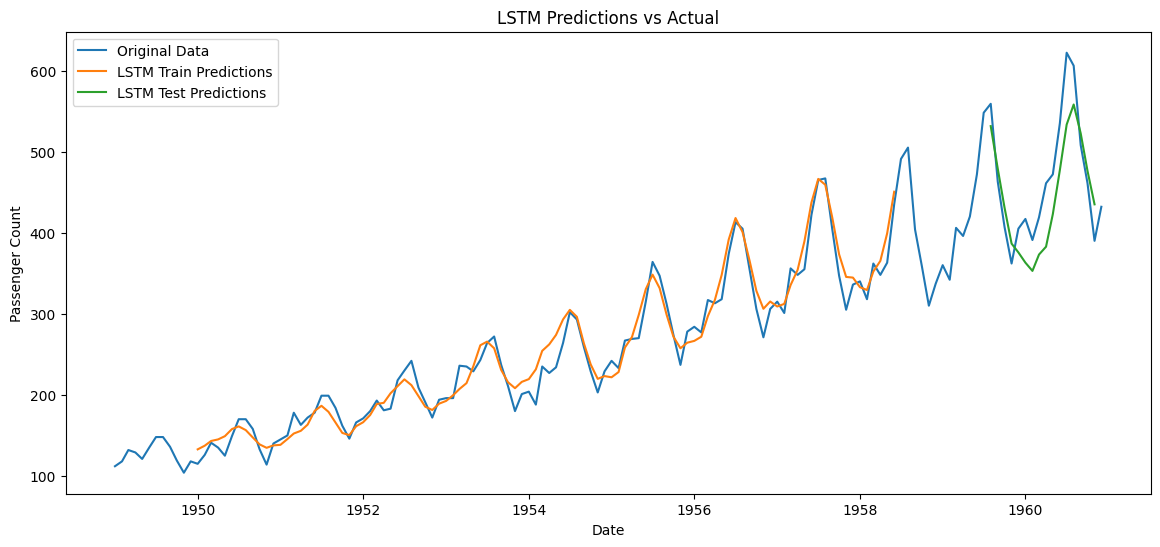

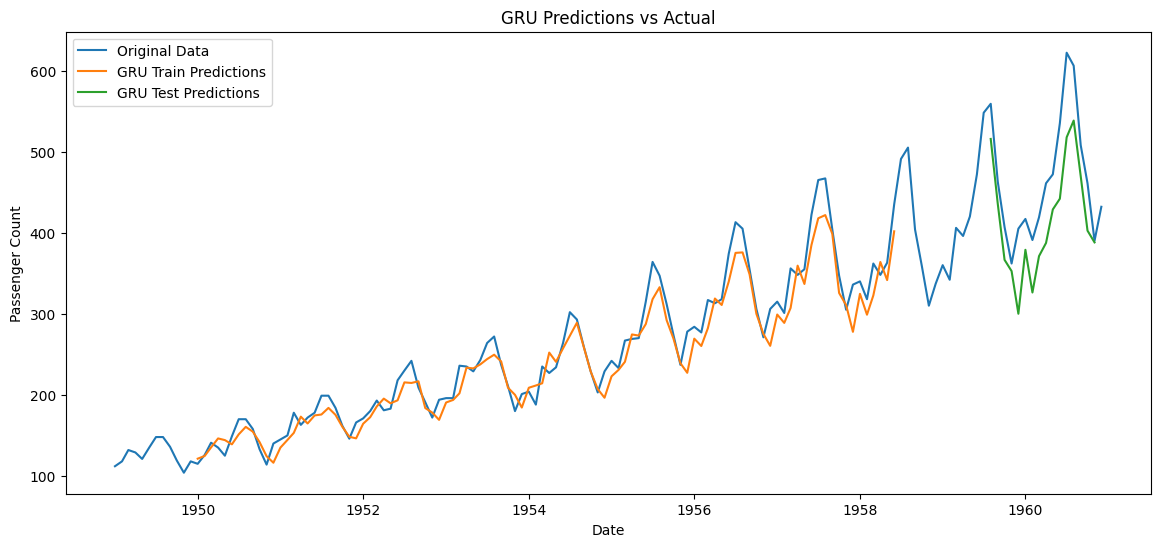

In [7]:
# Plot LSTM predictions
plt.figure(figsize=(14, 6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='Original Data')

# For training predictions
plt.plot(data.index[time_step:len(train_predict_lstm) + time_step], train_predict_lstm, label='LSTM Train Predictions')

# For test predictions (adjust the length of x and y to match)
plt.plot(data.index[len(train_predict_lstm) + (time_step * 2) + 1:len(train_predict_lstm) + (time_step * 2) + 1 + len(test_predict_lstm)], 
         test_predict_lstm, label='LSTM Test Predictions')

plt.title('LSTM Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()


# Plot GRU predictions
plt.figure(figsize=(14, 6))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='Original Data')

# For training predictions
plt.plot(data.index[time_step:len(train_predict_gru) + time_step], train_predict_gru, label='GRU Train Predictions')

# For test predictions (adjust the length of x and y to match)
plt.plot(data.index[len(train_predict_gru) + (time_step * 2) + 1:len(train_predict_gru) + (time_step * 2) + 1 + len(test_predict_gru)], 
         test_predict_gru, label='GRU Test Predictions')

plt.title('GRU Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

In [8]:
# Create a table for performance metrics comparison
performance_data = {
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru]
}

performance_df = pd.DataFrame(performance_data)

print(performance_df)


NameError: name 'rmse_lstm' is not defined

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# LSTM Evaluation
rmse_lstm = math.sqrt(mean_squared_error(y_test, test_predict_lstm))
mae_lstm = mean_absolute_error(y_test, test_predict_lstm)

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM MAE: {mae_lstm}")

# GRU Evaluation
rmse_gru = math.sqrt(mean_squared_error(y_test, test_predict_gru))
mae_gru = mean_absolute_error(y_test, test_predict_gru)

print(f"GRU RMSE: {rmse_gru}")
print(f"GRU MAE: {mae_gru}")


LSTM RMSE: 421.55137948216714
LSTM MAE: 416.8372325749931
GRU RMSE: 411.82205268644867
GRU MAE: 407.58932302909466
